In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam, SGD
from torchvision import datasets
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from typing import Any
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data_folder = './../../data/FMNIST/'

fmnist = datasets.FashionMNIST(data_folder, train=True, download=True)
tr_images = fmnist.data
tr_taregts = fmnist.targets

val_fmnist = datasets.FashionMNIST(data_folder, train=False, download=True)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [2]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y) -> None:
        super().__init__()
        x = x.float()/255
        x = x.view(-1,1,28,28)
        self.x, self.y = x, y
    def __getitem__(self, index) -> Any:
        return self.x[index].to(device), self.y[index].to(device)
    def __len__(self) -> int:
        return len(self.x)
    
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),    # L1
        nn.MaxPool2d(2),                    # L2
        nn.ReLU(),                          # L3
        nn.Conv2d(64,128,kernel_size=3),    # L4
        nn.MaxPool2d(2),                    # L5
        nn.ReLU(),                          # L6
        nn.Flatten(),                       # L7
        nn.Linear(3200, 256),               # L8
        nn.ReLU(),                          # L9
        nn.Linear(256, 10)                  # L10
    ).to(device)
    # layer 1
        # number of kernals in the first layer = 64
        # the size of input - -1x1x28x28
        # the size of output-image of the first layer will be 28-2 => -1x64x26x26
        # number of parameters : (1*64*3*3 kernel nodes) + (64 channel biases) = 640
    # layer 2
        # maxpooling will reduce the image-size to half => -1x64x13x13
    # layer 3
    # layer 4
        # number of kernals in the first layer = 128
        # input size will be same as the output size in layer 2
        # output size will be -1x128x11x11
        # number of parameters : (64*128*3*3 kernel nodes) + (128 channel biases) = 73856
    # layer 5
        # maxpooling will reduce the image-size to half => -1x128x5x5
    # layer 6
    # layer 7
        # this step will flatten the whole image from 128x5x5 to 3200x1
    # layer 8
        # number of parameters for this layer 3200*256 + 1*256 = 819456
    # layer 9
    # layer 10
        # number of parameters for this layer 256*10 + 1*10 = 2570
    loss_fn = nn.CrossEntropyLoss()
    optm = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optm

def train_batch(x, y, model, loss_fn, optimizer):
    model.train()
    prediction = model(x)
    loss_value = loss_fn(prediction, y)
    loss_value.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss_value.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [3]:
def get_data():
    train = FMNISTDataset(tr_images, tr_taregts)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val), shuffle=True)

    return trn_dl, val_dl

In [4]:
@torch.no_grad()
def val_loss(x, y, model, loss_fn):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [5]:
trn_dl, val_dl = get_data()
model, loss_fn, optm = get_model()

In [6]:
!pip install torch_summary
from torchsummary import summary
summary(model, torch.zeros(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8

In [7]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(trn_dl):
        x, y = batch
        batch_loss = train_batch(x, y, model, loss_fn, optm)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(trn_dl):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for ix, batch in enumerate(val_dl):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model, loss_fn) 
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


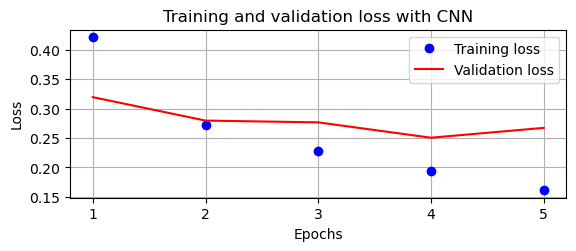

C:\Users\yashl\AppData\Local\Temp\ipykernel_7704\2472028946.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


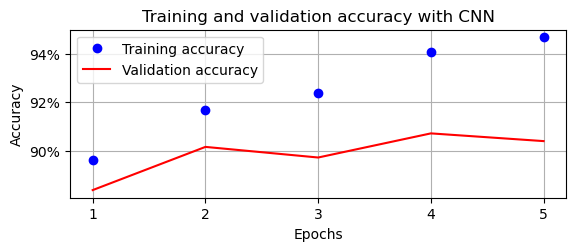

In [8]:
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

epochs = np.arange(5)+1
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

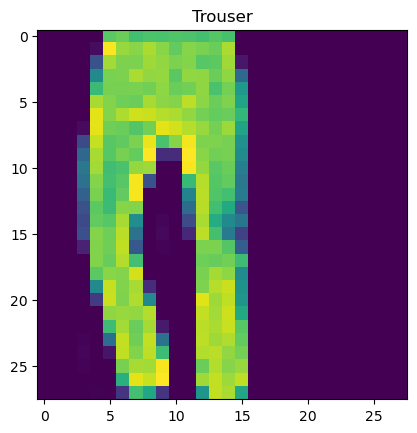

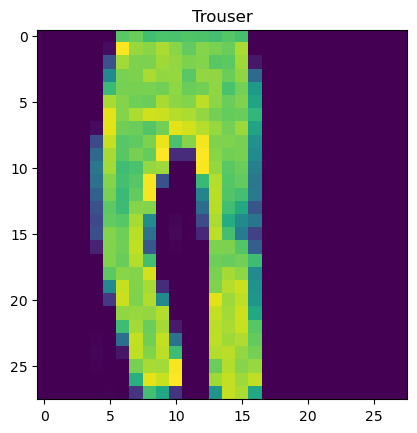

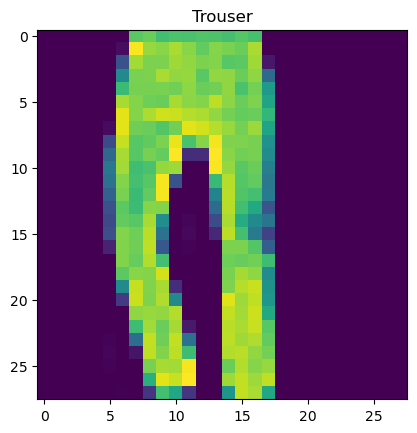

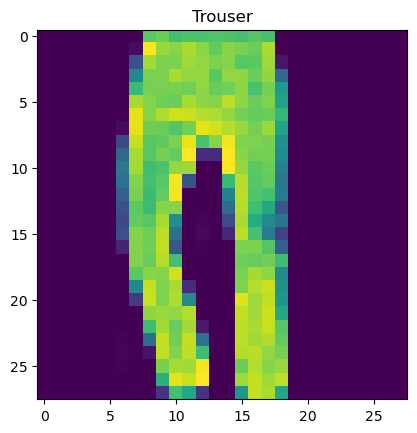

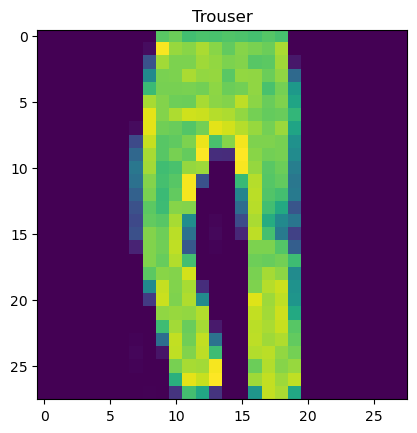

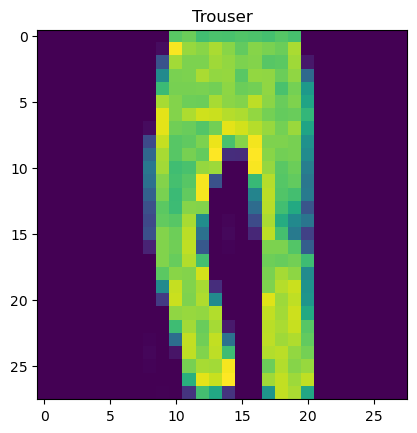

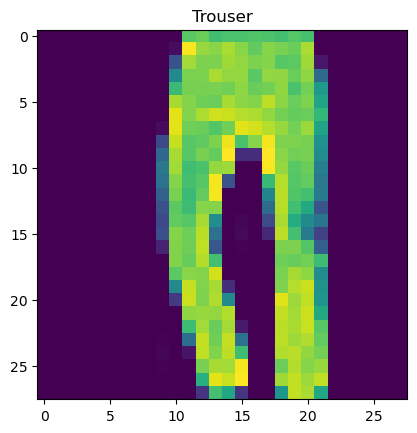

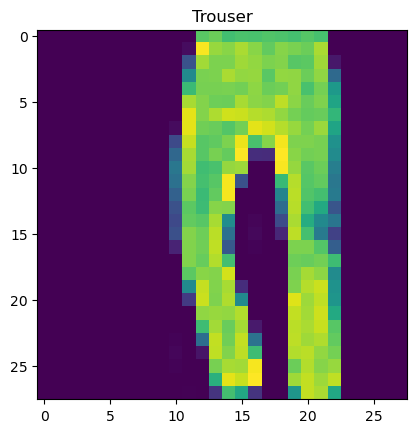

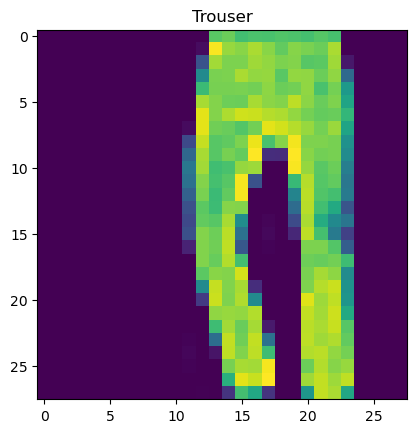

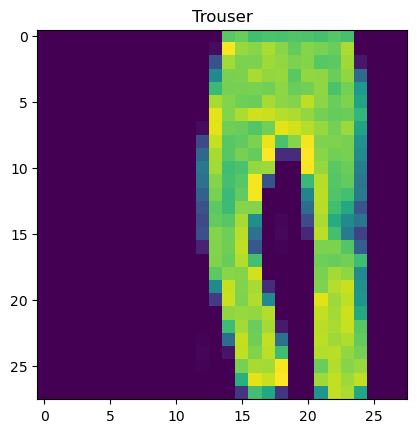

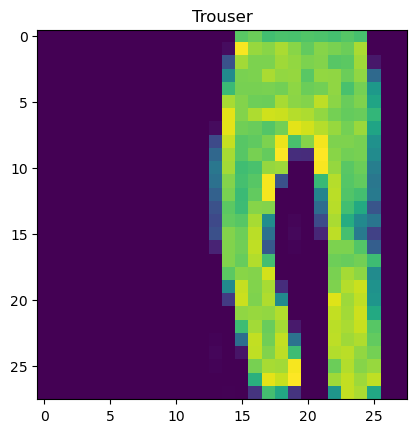

In [12]:
preds = []
ix = 24300
for px in range(-5,6):
  img = tr_images[ix]/255.
  img = img.view(28, 28)
  img2 = np.roll(img, px, axis=1)
  img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
  np_output = model(img3).cpu().detach().numpy()
  pred = np.exp(np_output)/np.sum(np.exp(np_output))
  preds.append(pred)
  plt.imshow(img2)
  plt.title(fmnist.classes[pred[0].argmax()])
  plt.show()

In [13]:
np.array(preds).shape

(11, 1, 10)

<Axes: title={'center': 'Probability of each class for various translations'}>

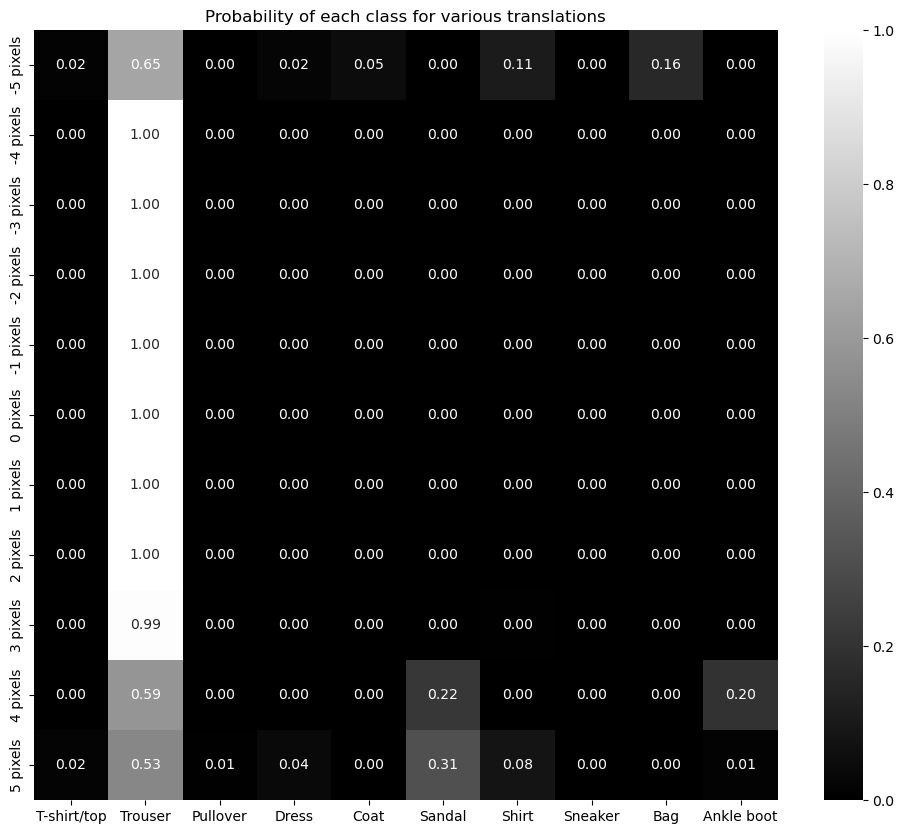

In [15]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds).reshape(11,10), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')